In [1]:
!pip install pyspark

In [47]:
#imports_section

import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.functions import col, count, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import expr
from pyspark.ml.classification import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [11]:
spark = SparkSession.builder.appName("Anti Money Laundering Detection System").config("spark.executor.memory", "6g").config("spark.driver.memory", "6g").getOrCreate()

In [12]:
data = spark.read.csv("LI-Medium_Trans.csv", header=True, inferSchema=True)

In [13]:
data.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:18|     3196|800107150|   3196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:23|     1208|80010E430|   1208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|     3203|80010EA80|   3203|80010EA80|       13284.41|         US Dollar|   13284.

In [12]:
data.describe().show(5)

+-------+----------------+-----------------+---------+-----------------+---------+-------------------+------------------+-------------------+-----------------+--------------+--------------------+
|summary|       Timestamp|        From Bank| Account2|          To Bank| Account4|    Amount Received|Receiving Currency|        Amount Paid| Payment Currency|Payment Format|       Is Laundering|
+-------+----------------+-----------------+---------+-----------------+---------+-------------------+------------------+-------------------+-----------------+--------------+--------------------+
|  count|        31251483|         31251483| 31251483|         31251483| 31251483|           31251483|          31251483|           31251483|         31251483|      31251483|            31251483|
|   mean|            NULL| 275257.405870851| Infinity|391286.1635868928| Infinity|  7953412.507903153|              NULL|  5392240.185796354|             NULL|          NULL|5.132876414216887E-4|
| stddev|           

In [38]:
null_counts = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_counts.show()

+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|        0|        0|       0|      0|       0|              0|                 0|          0|               0|             0|            0|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



In [14]:
data = data.withColumnRenamed("Account", "From").withColumnRenamed("Account.1", "To")
data.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|    8095.07|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:18|     3196|800107150|   3196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:23|     1208|80010E430|   1208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|     3203|80010EA80|   3203|80010EA80|       13284.41|         US Dollar|   13284.

In [15]:
Laundering = data[data['Is Laundering']==1]
Non_Laundering = data[data['Is Laundering']==0]

In [16]:
laundering_count = data.filter(data["Is Laundering"] == 1).count()
non_laundering_count = data.filter(data["Is Laundering"] == 0).count()

print("Number of Laundering cases:", laundering_count)
print("Number of Non-Laundering cases:", non_laundering_count)

Number of Laundering cases: 16041
Number of Non-Laundering cases: 31235442


In [17]:
diff_currency_trans = data.filter(data['Receiving Currency'] != data['Payment Currency'])
# Group by 'Receiving Currency' and 'Payment Currency' and count each group
inter_currency_counts = diff_currency_trans.groupBy('Receiving Currency', 'Payment Currency').count()
inter_currency_counts.describe().show()

+-------+------------------+-----------------+-----------------+
|summary|Receiving Currency| Payment Currency|            count|
+-------+------------------+-----------------+-----------------+
|  count|               208|              208|              208|
|   mean|              NULL|             NULL|2249.418269230769|
| stddev|              NULL|             NULL|9956.806586647941|
|    min| Australian Dollar|Australian Dollar|                1|
|    max|              Yuan|             Yuan|           101036|
+-------+------------------+-----------------+-----------------+



In [18]:
# same_currency_trans = Laundering[Laundering['Receiving Currency'] == Laundering['Payment Currency']]
# same_currencyL = same_currency_trans.groupby('Payment Currency').size().reset_index(name='Transaction Count')

# same_currencyL.describe()

same_currency_trans = data.filter(data['Receiving Currency'] == data['Payment Currency'])

# Group by 'Payment Currency' and count
same_currency_counts = same_currency_trans.groupBy('Payment Currency').count()

# Describe the counts
same_currency_counts.describe().show()


+-------+-----------------+------------------+
|summary| Payment Currency|             count|
+-------+-----------------+------------------+
|  count|               15|                15|
|   mean|             NULL|2052240.2666666666|
| stddev|             NULL| 3114979.467933926|
|    min|Australian Dollar|            631457|
|    max|             Yuan|          11592839|
+-------+-----------------+------------------+



In [19]:
same_curr = data.filter(col('Receiving Currency') == col('Payment Currency'))
cross_currL = data.filter(col('Receiving Currency') != col('Payment Currency'))

# Count the filtered transactions
same_curr_count = same_curr.count()
cross_curr_count = cross_currL.count()

# Print the counts
print("Number of transactions with the same currency:", same_curr_count)
print("Number of transactions with different currencies:", cross_curr_count)

Number of transactions with the same currency: 30783604
Number of transactions with different currencies: 467879


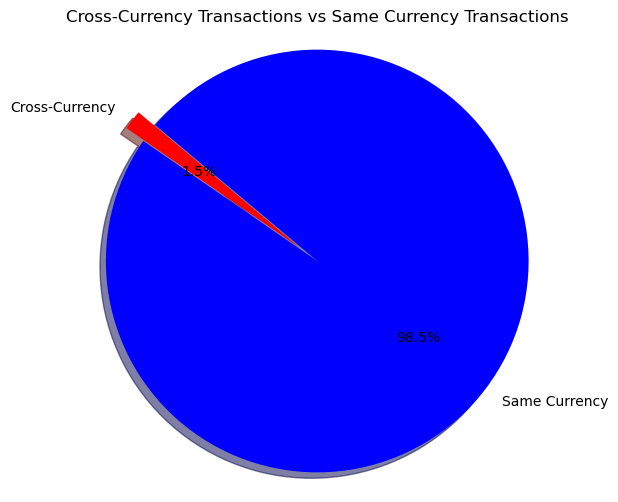

In [20]:
# Labels for the sections of our pie chart
labels = ['Cross-Currency', 'Same Currency']
sizes = [cross_curr_count, same_curr_count]  # The values are the counts from Spark
colors = ['red', 'blue']
explode = (0.1, 0)  # "explode" the 1st slice (i.e., 'Cross-Currency')

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Cross-Currency Transactions vs Same Currency Transactions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


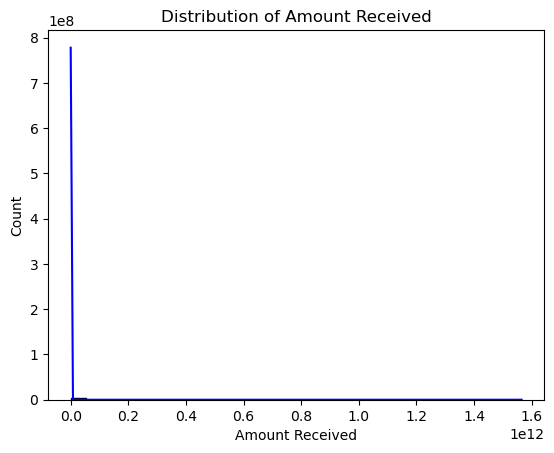

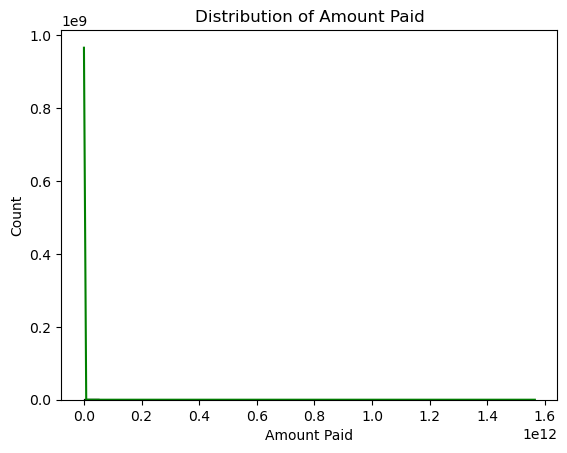

In [34]:
sample_df = data.select("Amount Received", "Amount Paid").sample(fraction=0.1).toPandas()

sns.histplot(sample_df, x="Amount Received", bins=30, color='blue', kde=True)
plt.title('Distribution of Amount Received')
plt.show()

sns.histplot(sample_df, x="Amount Paid", bins=30, color='green', kde=True)
plt.title('Distribution of Amount Paid')
plt.show()

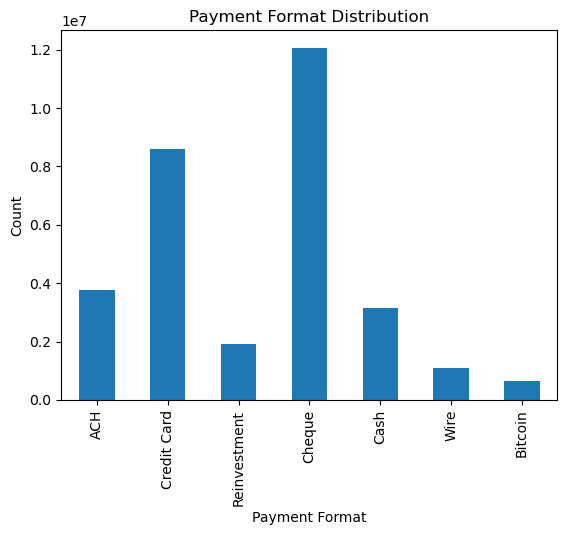

In [21]:
category_counts = data.groupBy("Payment Format").count()

# Collect data and plot
category_counts_pd = category_counts.toPandas()
category_counts_pd.plot(kind='bar', x='Payment Format', y='count', legend=None)
plt.title('Payment Format Distribution')
plt.ylabel('Count')
plt.show()

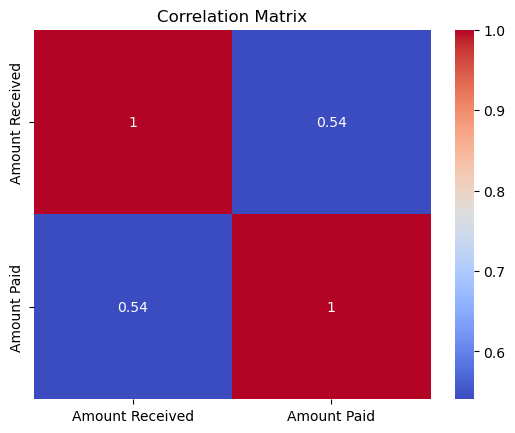

In [22]:
numeric_features = ["Amount Received", "Amount Paid"]
numeric_data = data.select(numeric_features).sample(fraction=0.1).toPandas()

corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [23]:
# Assuming 'Account' and other categorical features need transformation
indexers = [
    StringIndexer(inputCol=column, outputCol=column+"_index").fit(data)
    for column in ["Receiving Currency", "Payment Currency", "Payment Format"]
]

# Apply OneHotEncoder if categorical features are nominal
encoder = OneHotEncoder(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[indexer.getOutputCol().replace("_index", "_vec") for indexer in indexers]
)

# Assemble all features into one vector (including newly created dummy features)
assembler = VectorAssembler(
    inputCols=[indexer.getOutputCol().replace("_index", "_vec") for indexer in indexers] + ["Amount Received", "Amount Paid"],
    outputCol="features"
)

# Pipeline for transformations
pipeline = Pipeline(stages=indexers + [encoder, assembler])
transformed_df = pipeline.fit(data).transform(data)

transformed_df.show(5)  # Viewing the transformed DataFrame


+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+------------------------+----------------------+--------------------+----------------------+--------------------+------------------+--------------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Receiving Currency_index|Payment Currency_index|Payment Format_index|Receiving Currency_vec|Payment Currency_vec|Payment Format_vec|            features|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+------------------------+----------------------+--------------------+----------------------+--------------------+------------------+--------------------+
|2022/09/01 00:15|       20|800104D70|     20|800104D70|        8095.07|         US Dollar|

In [24]:
# Split the data
train_data, test_data = transformed_df.randomSplit([0.3, 0.7], seed=42)

In [25]:
# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='Is Laundering', maxIter=10)

# Train the model
lr_model = lr.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)


In [26]:
evaluator = BinaryClassificationEvaluator(labelCol="Is Laundering", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Test Area Under ROC: ", auc)


Test Area Under ROC:  0.8228369630486096


In [29]:
# Assuming binary classification prediction is in the column 'prediction'
accuracy_df = predictions.withColumn('correct', expr("cast(prediction = `Is Laundering` as int)"))
accuracy = accuracy_df.agg({"correct": "avg"}).collect()[0]['avg(correct)']

print("Accuracy of the model: ", accuracy)


Accuracy of the model:  0.9994866301417735


In [33]:
# plt.figure(figsize=(18, 6))
# sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currencyL)
# plt.title('Laundering transaction Counts by Currency')
# plt.xlabel('Currency')
# plt.ylabel('Transaction Count')
# plt.show()

# plt.figure(figsize=(6, 6))
# plt.pie(same_currencyL['Transaction Count'], labels=same_currencyL['Payment Currency'], autopct='%1.1f%%', startangle=15)
# plt.title('Distribution of Payment Currency in Money Laundering Transactions')
# plt.axis('equal')
# plt.show()

# Collect data to local Pandas DataFrame for plotting
same_currency_pd = same_curr_count.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot
plt.figure(figsize=(18, 6))
sns.barplot(x='Payment Currency', y='Transaction Count', data=same_currency_pd)
plt.title('Laundering Transaction Counts by Currency')
plt.xlabel('Currency')
plt.ylabel('Transaction Count')
plt.show()
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(same_currencyL_pd['Transaction Count'], labels=same_currencyL_pd['Payment Currency'], autopct='%1.1f%%', startangle=15)
plt.title('Distribution of Payment Currency in Money Laundering Transactions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


AttributeError: 'int' object has no attribute 'toPandas'

In [ ]:
payment_formatL = Laundering.groupby('Payment Format').size().reset_index(name='Transaction Count')
payment_formatL.head()

,Payment Format,Transaction Count
0,ACH,30746
1,Bitcoin,244
2,Cash,666
3,Cheque,2220
4,Credit Card,1354


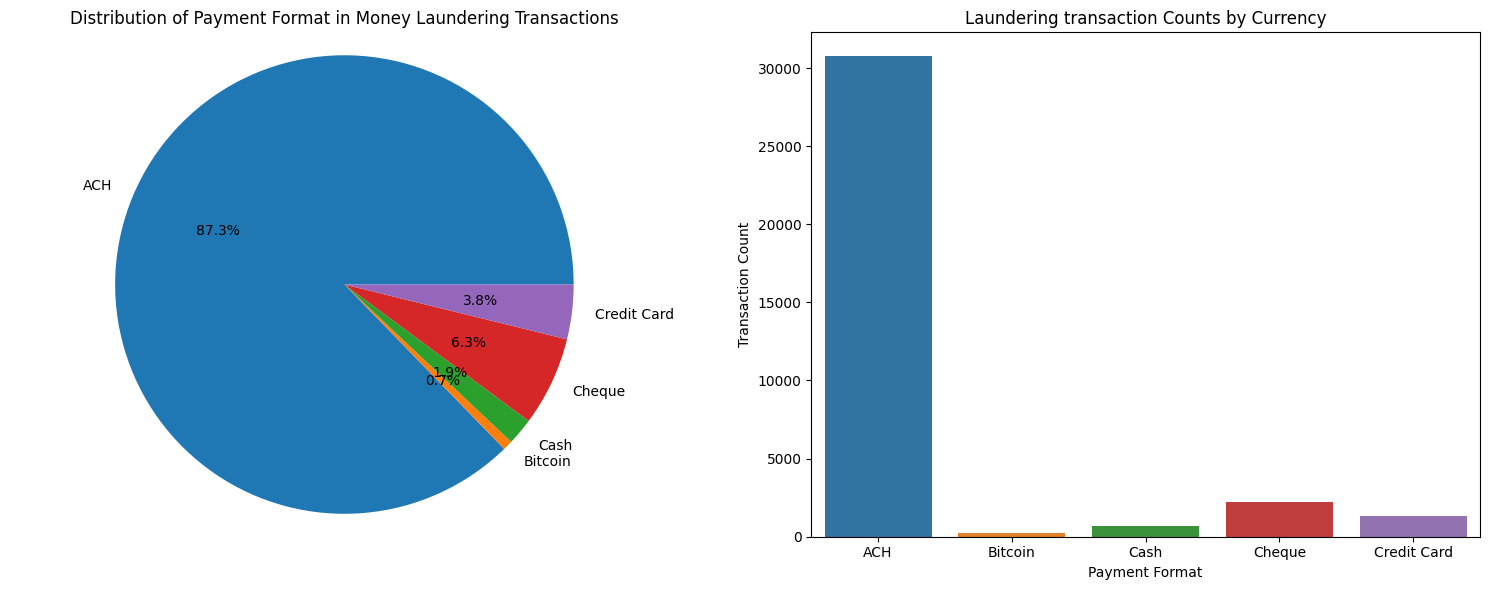

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].pie(payment_formatL['Transaction Count'], labels=payment_formatL['Payment Format'], autopct='%1.1f%%', startangle=0)
axes[0].set_title('Distribution of Payment Format in Money Laundering Transactions')
axes[0].axis('equal')


sns.barplot(x='Payment Format', y='Transaction Count', data=payment_formatL,ax=axes[1])
axes[1].set_title('Laundering transaction Counts by Currency')
axes[1].set_xlabel('Payment Format')
axes[1].set_ylabel('Transaction Count')
plt.tight_layout()
plt.show()

/tmp/ipykernel_18/1191750622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
/tmp/ipykernel_18/1191750622.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Laundering['Day'] = Laundering['Timestamp'].dt.day


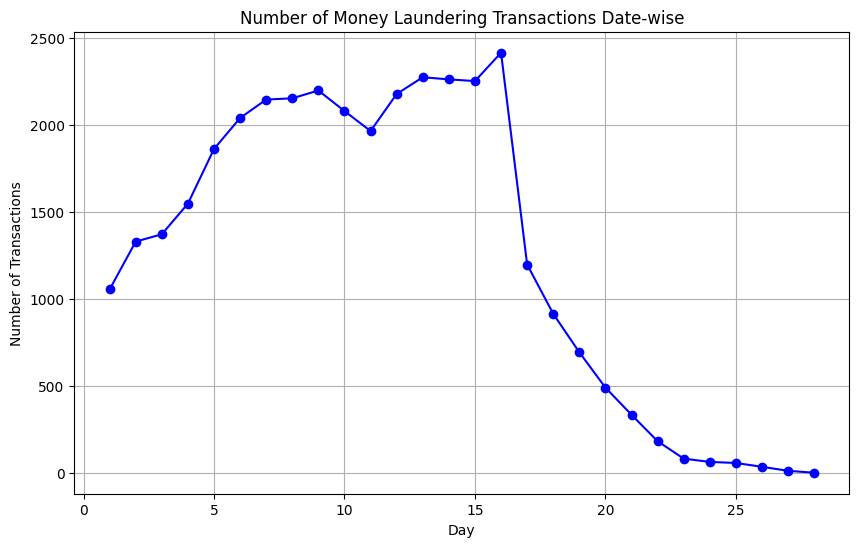

In [ ]:
Laundering['Timestamp'] = pd.to_datetime(Laundering['Timestamp'])
Laundering['Day'] = Laundering['Timestamp'].dt.day
daily_transactions = Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

/tmp/ipykernel_18/1252191665.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
/tmp/ipykernel_18/1252191665.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day


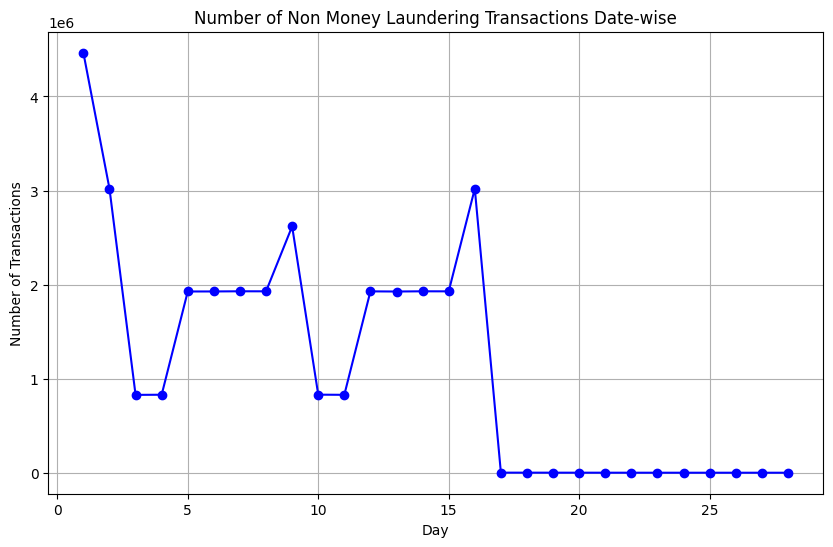

In [ ]:
Non_Laundering['Timestamp'] = pd.to_datetime(Non_Laundering['Timestamp'])
Non_Laundering['Day'] = Non_Laundering['Timestamp'].dt.day
daily_transactions = Non_Laundering.groupby('Day').size()

daily_transactions.plot(kind='line', marker='o', color='b', figsize=(10, 6))
plt.title('Number of Non Money Laundering Transactions Date-wise')
plt.xlabel('Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [44]:
categoricalColumns = ['Receiving Currency', 'Payment Currency', 'Payment Format']
stages = []  # stages in our Pipeline

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

# Assemble numeric columns with categorical vectorized columns into one feature column
numericCols = ['Amount Received', 'Amount Paid']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
stages += [scaler]

In [45]:
rf = RandomForestClassifier(labelCol="Is Laundering", featuresCol="scaledFeatures")
stages += [rf]

# Create the pipeline
pipeline = Pipeline(stages=stages)

# Train-test split
(train, test) = data.randomSplit([0.2, 0.8], seed=42)

# Fit the model
model = pipeline.fit(train)

In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions
predictions = model.transform(test)

# Evaluate model
evaluator = BinaryClassificationEvaluator(labelCol="Is Laundering")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print(f"Area under ROC = {accuracy}")

Area under ROC = 0.5
